In [2]:
from scipy.io import netcdf
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import math
import os,sys
import matplotlib.style

import matplotlib

matplotlib.style.use('classic')
import time

In [3]:
# Disable
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    sys.stdout = sys.__stdout__

In [27]:
m1['aqc_stat2_lwp']

<class 'netCDF4._netCDF4.Variable'>
int32 aqc_stat2_lwp(time)
    long_name: Ancillary QC input stat2_lwp derived from MWRRET VAP.
    units: unitless
    comment: Nearest qc_stat2_lwp bit value in time.
unlimited dimensions: time
current shape = (21600,)
filling on, default _FillValue of -2147483647 used

In [4]:
import glob,os,sys
os.chdir('C:/Users/yashg/Documents/Cloud_Data_Files')
def read_files(extensions,location):
    l=[]
    for types in extensions:
        l.append(glob.glob(f'./{location}/*{types}'))
    l=[val for sublist in l for val in sublist]
    return l

k=read_files(['.cdf','.nc'],'KAZRARSCL')
m=read_files(['.cdf','.nc'],'Microbase')
r=read_files(['.cdf','.nc'],'Raman Lidar')
s=read_files(['.cdf','.nc'],'Surface')
e=read_files(['.cdf','.nc'],'Ext')
mp=read_files(['.cdf','.nc'],'Micropulse')
master=k+m+r+s+e+mp

def date_files(date,master=master):
    f=[]
    for file in master:
        if date in file:
            f.append(file)
    return f

def generate_cdfs(date):
    l=[]
    f=date_files(date)
    for file in f:
        l.append(Dataset(file))
    print('Output has 6 files')
    print('File order is\t1.KAZRARSCL\t2.Microbase\t3.Raman Lidar\t4. Surface\t5. Ext\t6.Micropulse')
    return l

In [25]:
k1,m1,r1,s1,e1,mp1=generate_cdfs('20110513')

In [10]:
tk=k1['time'][:]
hk=k1['height'][:]
tr=r1['time'][:]
hr=r1['height'][:]*1000
ref=10**(k1['reflectivity'][:]/10)
v=np.abs(k1['mean_doppler_velocity'][:])
temp=r1['temperature'][:]+273.15
lwc_mb=m1['liquid_water_content'][:]
varss=['Reflectivity','Velocity','Temperature','LWC']
shp=[ref.shape,v.shape,temp.shape,lwc_mb.shape]
for i,x in enumerate(varss):
    print(f'{x}:{shp[i]}')

Reflectivity:(21600, 596)
Velocity:(21600, 596)
Temperature:(144, 198)
LWC:(21600, 596)


In [5]:
def st_clustering(t1,h1,t2,h2):
    t_clust=[]
    h_clust=[]
    output_resolution=(len(t1),len(h1))
    data_resolution=(len(t2),len(h2))
    print('--------Start of clustering cycle--------')
    print(f'Changing time resolution from {len(t2)}->{len(t1)}')
    print(f'Changing height resolution from {len(h2)}->{len(h1)}')
    if len(t1)>len(t2):
        print('You are increasing time resolution')
        for i in t1:
            x=np.argmin(np.abs(i-t2))
            t_clust.append(x)
    else:
        print('You are decreasing time resolution')
        for i in range(len(t1)):
            if i!=len(t1)-1:
                ltemp=[m for m,x in enumerate(t2) if t1[i]<= x <=t1[i+1]]
                t_clust.append(ltemp)
            else:
                ltemp=[m for m,x in enumerate(t2) if t1[i]<= x]
                t_clust.append(ltemp) 
    if len(h1)>len(h2):
        print('You are increasing height resolution')
        for i in h1:
            x=np.argmin(np.abs(i-h2))
            h_clust.append(x)
    else:
        print('You are decreasing height resolution')     
        for i in range(len(h1)):
            if i!=len(h1)-1:
                ltemp=[m for m,x in enumerate(h2) if h1[i]<= x <=h1[i+1]]
                h_clust.append(ltemp)
            else:
                ltemp=[m for m,x in enumerate(h2) if h1[i]<= x]
                h_clust.append(ltemp) 
    print('--------End of clustering cycle--------')
    return t_clust,h_clust

In [12]:
tc,hc=st_clustering(tk,hk,tr,hr)
temp_cl=[]
for i in tc:
    for j in hc:
        temp_cl.append(temp[i,j])
temp_cl=np.array(temp_cl)
temp_cl=np.reshape(temp_cl,(len(tk),len(hk)))

--------Start of clustering cycle--------
Changing time resolution from 144->21600
Changing height resolution from 198->596
You are increasing time resolution
You are increasing height resolution
--------End of clustering cycle--------


In [13]:
ts=np.ma.filled(s1['time'][:])
ccn=np.ma.filled(s1['N_CCN'][:])
tc2,dummy=st_clustering(tk,hk,ts,hr)
ccn_ts=[ccn[i] for i in tc2]

--------Start of clustering cycle--------
Changing time resolution from 1440->21600
Changing height resolution from 198->596
You are increasing time resolution
You are increasing height resolution
--------End of clustering cycle--------


In [14]:
u=[]
for p in ccn_ts:
    u.append([p]*len(hk))
ccn_cl=np.array(u)

In [11]:
#Parameters
A=8.07131
B=1730.63
C=233.426
l=2260000 #J/kg
a_cond=0.022 #W/m/K
a_water=5.5575 #W/m/K
D=0.399*10**-4 #m^2/s
Ra=287 #J/deg/kg
Rv=461 #J/deg/kg
qv=0.04 #kg/kg
rhow=1000 #kg/m3
rhoa=1.225 #kg/m3
g=9.8 #m2/s
cp=1000 #J/kg
C1=1.058 

In [12]:
def vaporpressure(temp):
    p=10**(A-(B)/(C+temp))
    p=p*133.322
    return p #in pascals

def constants(temp):
    vp=vaporpressure(temp-273.15)
    k=(1.52E-11)*(temp)**3-(4.8574E-8)*(temp)**2+1.0184E-04*(temp)-3.9333E-04
    F=(rhow*(l)**2/k/Rv/(temp)**2)+(rhow*Rv*(temp)/vp/D)
    A1=(g/Ra/temp*((l*Ra/(cp*Rv*temp))-1))
    A2=1/qv+((l)**2/cp/Rv/(temp)**2)
    return k,F,A1,A2

def C3(temp):
    k,F,A1,A2=constants(temp)
    a=C1*(F*A1/3)**0.75
    b=(3*rhoa/4/np.pi/rhow/A2)**0.5
    return a*b

def CDC_pinsky(temp,No,v,k):
    C=C3(temp)/10
    a=C**(2*k/(2+k))
    b=(No)**(2/(2+k))
    c=np.abs(v)**(3*k/(4+2*k))
    return a*b*c

In [17]:
nt=CDC_pinsky(temp_cl,ccn_cl,v,0.5)
nt.shape

(21600, 596)

In [7]:
def lwc_val(z,n,alpha=5,rhowa=1e-3):
    pf=np.pi/6*(math.factorial(3+alpha))/np.sqrt(math.factorial(6+alpha)*math.factorial(alpha))
    lw=pf*rhowa*np.sqrt(z*n)
    return lw*(10**3)
#lwc_cal=lwc_val(ref,nt)

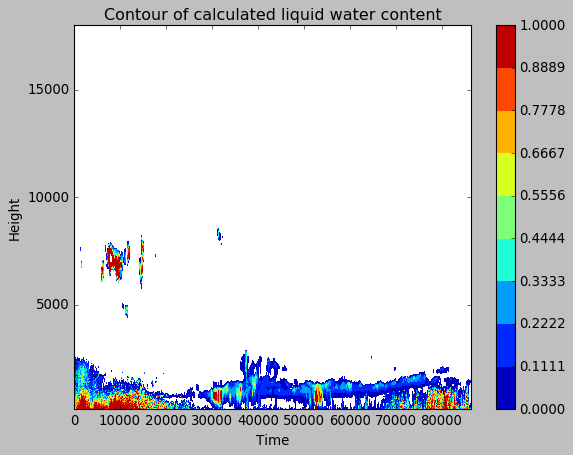

In [19]:
plt.contourf(tk,hk,lwc_cal.T,levels=np.linspace(1e-10,1,10))
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('Height')
plt.title('Contour of calculated liquid water content')
plt.show()

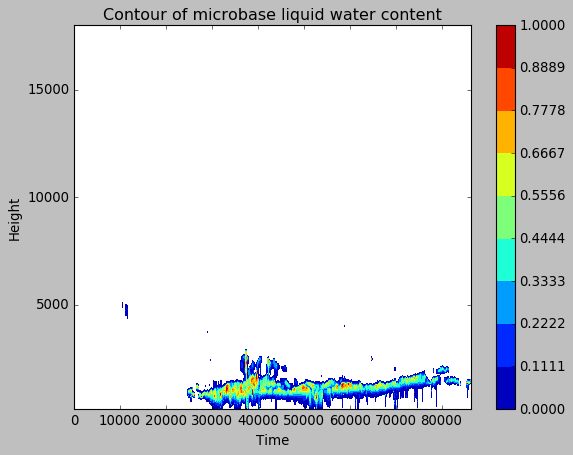

In [20]:
plt.contourf(tk,hk,lwc_mb.T,levels=np.linspace(1e-10,1,10))
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('Height')
plt.title('Contour of microbase liquid water content')
plt.show()

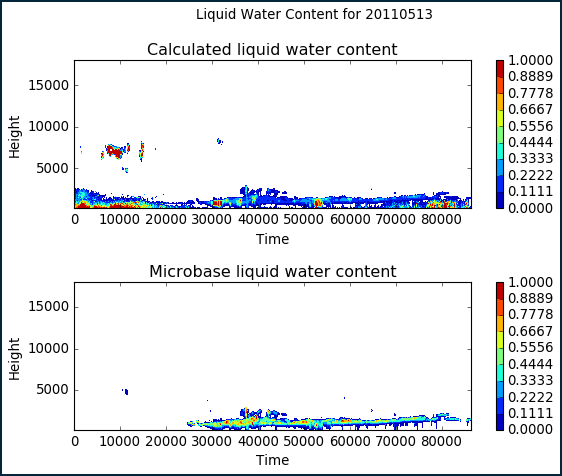

In [21]:
fig, (ax1, ax2) = plt.subplots(2,facecolor='white',linewidth=2,edgecolor="#04253a")
fig.suptitle(f'Liquid Water Content for 20110513')
p1=ax1.contourf(tk,hk,lwc_cal.T,levels=np.linspace(1e-10,1,10))
plt.colorbar(p1,ax=ax1)
ax1.set(xlabel='Time',ylabel='Height')
ax1.title.set_text('Calculated liquid water content')
p2=ax2.contourf(tk,hk,lwc_mb.T,levels=np.linspace(1e-10,1,10))
plt.colorbar(p2,ax=ax2)
ax2.set(xlabel='Time',ylabel='Height')
ax2.title.set_text('Microbase liquid water content')
plt.subplots_adjust(hspace=0.5,top=0.87)
plt.show()

In [9]:
days=[]
for x in mp:
    days.append(x[-18:-10])

In [22]:
def lwc_calculation(dat):
    print(f'--------Estimating LWC for {dat}--------------')
    k1,m1,r1,s1,e1,mp1=generate_cdfs(dat)
    tk=k1['time'][:]
    hk=k1['height'][:]
    tr=r1['time'][:]
    hr=r1['height'][:]*1000
    ref=10**(k1['reflectivity'][:]/10)
    v=np.abs(k1['mean_doppler_velocity'][:])
    temp=r1['temperature'][:]+273.15
    lwc_mb=m1['liquid_water_content'][:]
    tc,hc=st_clustering(tk,hk,tr,hr)
    temp_cl=[]
    for i in tc:
        for j in hc:
            temp_cl.append(temp[i,j])
    temp_cl=np.array(temp_cl)
    temp_cl=np.reshape(temp_cl,(len(tk),len(hk)))
    ts=np.ma.filled(s1['time'][:])
    ccn=np.ma.filled(s1['N_CCN'][:])
    tc2,dummy=st_clustering(tk,hk,ts,hr)
    ccn_ts=[ccn[i] for i in tc2]
    u=[]
    for p in ccn_ts:
        u.append([p]*len(hk))
    ccn_cl=np.array(u)
    nt=CDC_pinsky(temp_cl,ccn_cl,v,0.5)
    lwc_cal=lwc_val(ref,nt)d
    print(f'Plotting for {dat}')
    fig, (ax1, ax2) = plt.subplots(2,facecolor='white',linewidth=2,edgecolor="#04253a")
    fig.suptitle(f'Liquid Water Content for {dat}')
    p1=ax1.contourf(tk,hk,lwc_cal.T,levels=np.linspace(1e-10,1,10))
    plt.colorbar(p1,ax=ax1)
    ax1.set(xlabel='Time',ylabel='Height')
    ax1.title.set_text('Calculated liquid water content')
    p2=ax2.contourf(tk,hk,lwc_mb.T,levels=np.linspace(1e-10,1,10))
    plt.colorbar(p2,ax=ax2)
    ax2.set(xlabel='Time',ylabel='Height')
    ax2.title.set_text('Microbase liquid water content')
    plt.subplots_adjust(hspace=0.5,top=0.87)
#    plt.savefig(f'C:/Users/yashg/OneDrive/Desktop/CMU/Project/Plots/lwc_calculation/{dat}')
    plt.show()    
    return lwc_cal

20110505
--------Estimating LWC for 20110505--------------
Output has 6 files
File order is	1.KAZRARSCL	2.Microbase	3.Raman Lidar	4. Surface	5. Ext	6.Micropulse
--------Start of clustering cycle--------
Changing time resolution from 144->21600
Changing height resolution from 198->596
You are increasing time resolution
You are increasing height resolution
--------End of clustering cycle--------
--------Start of clustering cycle--------
Changing time resolution from 1440->21600
Changing height resolution from 198->596
You are increasing time resolution
You are increasing height resolution
--------End of clustering cycle--------


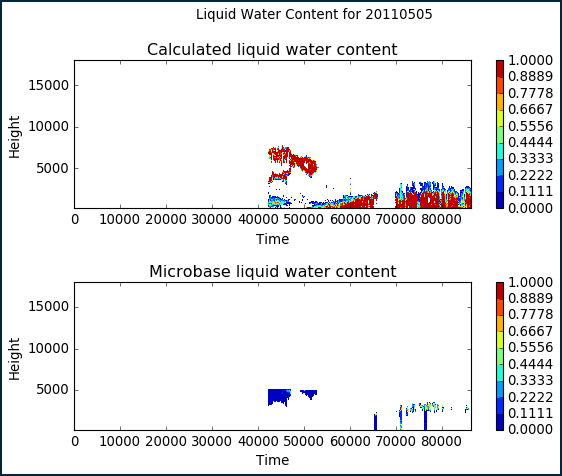

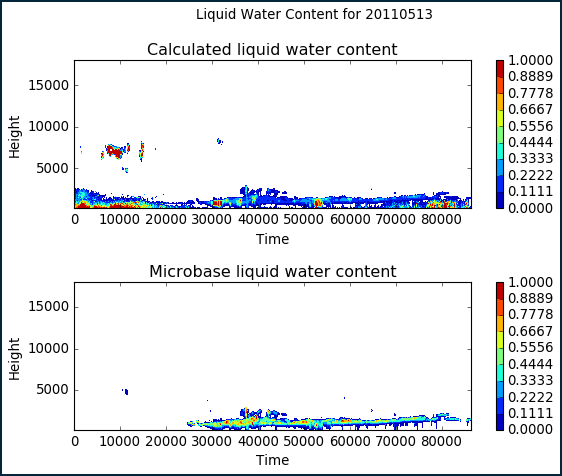

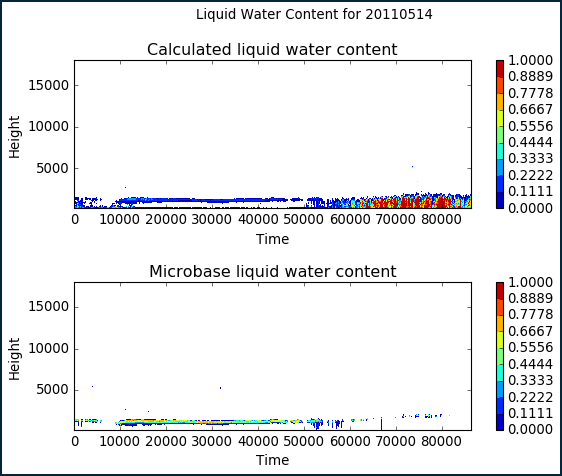

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Warning: converting a masked element to nan.


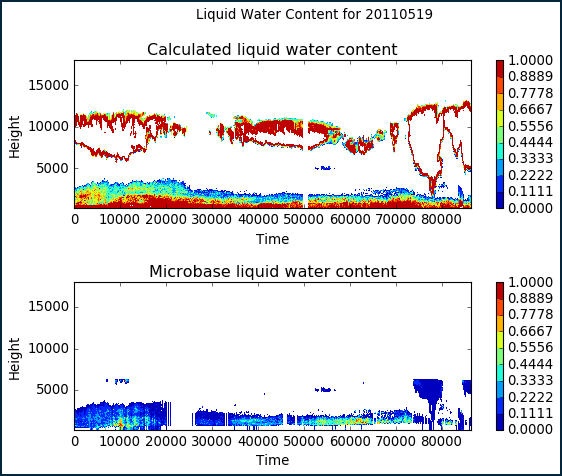

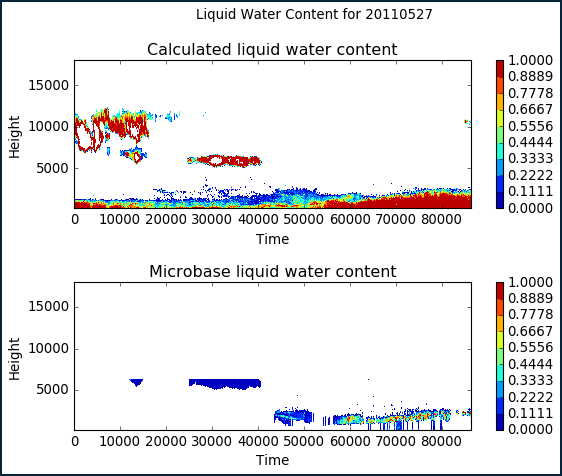

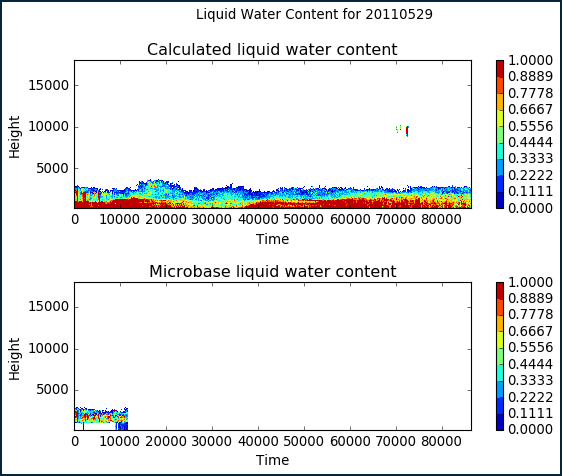

In [23]:
for d in days:
    print(d)
    ll=lwc_calculation(d)

In [18]:
#Calculating LWP:
def lwp(lw,h):
    p=np.trapz(lw,h)
    return p

In [20]:
def lwp_val(dat):
    print(f'-------{dat}-------')
    k1,m1,r1,s1,e1,mp1=generate_cdfs(dat)
    tk=k1['time'][:]
    hk=k1['height'][:]
    tr=r1['time'][:]
    hr=r1['height'][:]*1000
    ref=10**(k1['reflectivity'][:]/10)
    v=np.abs(k1['mean_doppler_velocity'][:])
    temp=r1['temperature'][:]+273.15
    lwc_mb=m1['liquid_water_content'][:]
    tc,hc=st_clustering(tk,hk,tr,hr)
    temp_cl=[]
    for i in tc:
        for j in hc:
            temp_cl.append(temp[i,j])
    temp_cl=np.array(temp_cl)
    temp_cl=np.reshape(temp_cl,(len(tk),len(hk)))
    ts=np.ma.filled(s1['time'][:])
    ccn=np.ma.filled(s1['N_CCN'][:])
    tc2,dummy=st_clustering(tk,hk,ts,hr)
    ccn_ts=[ccn[i] for i in tc2]
    u=[]
    for p in ccn_ts:
        u.append([p]*len(hk))
    ccn_cl=np.array(u)
    nt=CDC_pinsky(temp_cl,ccn_cl,v,0.5)
    lwc_cal=lwc_val(ref,nt)
    lwp_val=[]
    lwp_mb=[]
    print('Calculating LWP')
    for x in lwc_cal:
        lwpp=np.trapz(x,hk)
        lwp_val.append(lwpp)
    for x in lwc_mb:
        lwpp=np.trapz(x,hk)
        lwp_mb.append(lwpp)
    fig, (ax1, ax2) = plt.subplots(2,facecolor='white',linewidth=2,edgecolor="#04253a")
    ax1.plot(tk,lwp_val)
    ax1.set(xlabel='Time',ylabel='LWP')
    ax1.title.set_text('Calculated LWP')
    ax2.plot(tk,lwp_mb)
    ax2.set(xlabel='Time',ylabel='LWP')
    ax2.title.set_text('Microbase LWP')
    plt.subplots_adjust(hspace=0.5,top=0.87)
    plt.savefig(f'C:/Users/yashg/OneDrive/Desktop/CMU/Project/Plots/lwc_calculation/lwp_{dat}')
    plt.show()
    return lwc_cal,lwp_val

-------20110505-------
Output has 6 files
File order is	1.KAZRARSCL	2.Microbase	3.Raman Lidar	4. Surface	5. Ext	6.Micropulse
--------Start of clustering cycle--------
Changing time resolution from 144->21600
Changing height resolution from 198->596
You are increasing time resolution
You are increasing height resolution
--------End of clustering cycle--------
--------Start of clustering cycle--------
Changing time resolution from 1440->21600
Changing height resolution from 198->596
You are increasing time resolution
You are increasing height resolution
--------End of clustering cycle--------
Calculating LWP


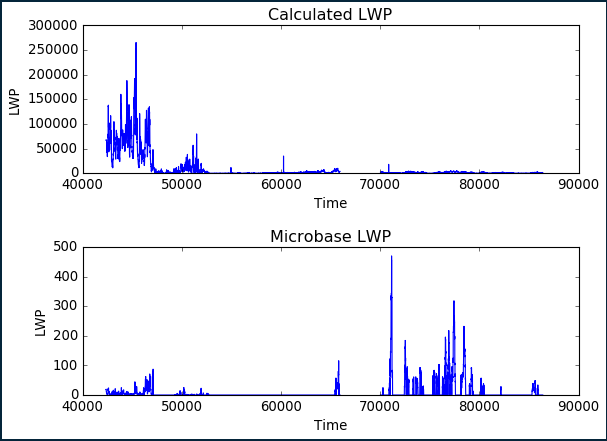

-------20110513-------
Output has 6 files
File order is	1.KAZRARSCL	2.Microbase	3.Raman Lidar	4. Surface	5. Ext	6.Micropulse
--------Start of clustering cycle--------
Changing time resolution from 144->21600
Changing height resolution from 198->596
You are increasing time resolution
You are increasing height resolution
--------End of clustering cycle--------
--------Start of clustering cycle--------
Changing time resolution from 1440->21600
Changing height resolution from 198->596
You are increasing time resolution
You are increasing height resolution
--------End of clustering cycle--------
Calculating LWP


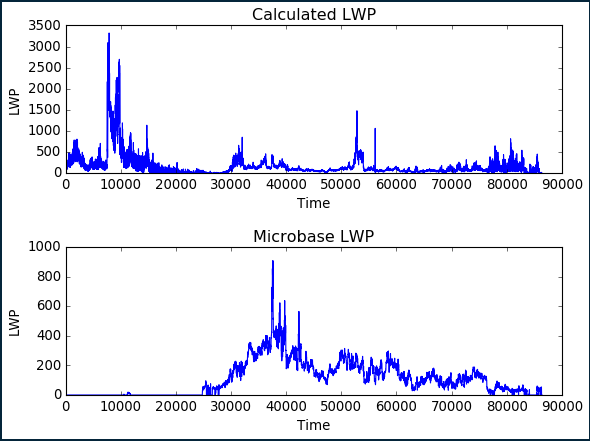

-------20110514-------
Output has 6 files
File order is	1.KAZRARSCL	2.Microbase	3.Raman Lidar	4. Surface	5. Ext	6.Micropulse
--------Start of clustering cycle--------
Changing time resolution from 144->21600
Changing height resolution from 198->596
You are increasing time resolution
You are increasing height resolution
--------End of clustering cycle--------
--------Start of clustering cycle--------
Changing time resolution from 1440->21600
Changing height resolution from 198->596
You are increasing time resolution
You are increasing height resolution
--------End of clustering cycle--------
Calculating LWP


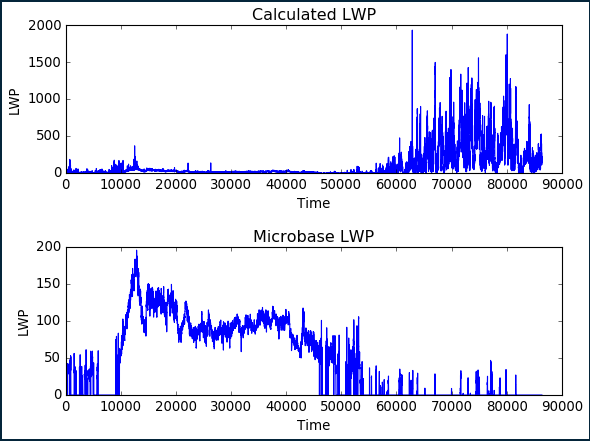

-------20110519-------
Output has 6 files
File order is	1.KAZRARSCL	2.Microbase	3.Raman Lidar	4. Surface	5. Ext	6.Micropulse
--------Start of clustering cycle--------
Changing time resolution from 144->21600
Changing height resolution from 198->596
You are increasing time resolution
You are increasing height resolution
--------End of clustering cycle--------


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Warning: converting a masked element to nan.


--------Start of clustering cycle--------
Changing time resolution from 1440->21600
Changing height resolution from 198->596
You are increasing time resolution
You are increasing height resolution
--------End of clustering cycle--------
Calculating LWP


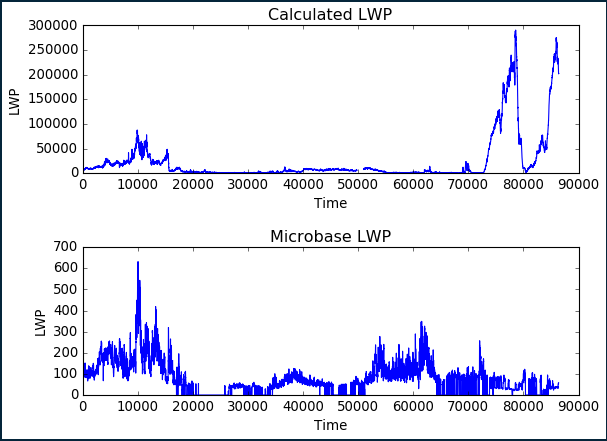

-------20110527-------
Output has 6 files
File order is	1.KAZRARSCL	2.Microbase	3.Raman Lidar	4. Surface	5. Ext	6.Micropulse
--------Start of clustering cycle--------
Changing time resolution from 144->21600
Changing height resolution from 198->596
You are increasing time resolution
You are increasing height resolution
--------End of clustering cycle--------
--------Start of clustering cycle--------
Changing time resolution from 1440->21600
Changing height resolution from 198->596
You are increasing time resolution
You are increasing height resolution
--------End of clustering cycle--------
Calculating LWP


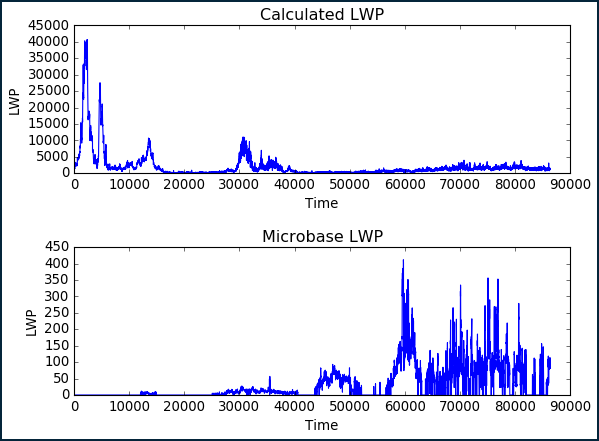

-------20110529-------
Output has 6 files
File order is	1.KAZRARSCL	2.Microbase	3.Raman Lidar	4. Surface	5. Ext	6.Micropulse
--------Start of clustering cycle--------
Changing time resolution from 144->21600
Changing height resolution from 198->596
You are increasing time resolution
You are increasing height resolution
--------End of clustering cycle--------
--------Start of clustering cycle--------
Changing time resolution from 1440->21600
Changing height resolution from 198->596
You are increasing time resolution
You are increasing height resolution
--------End of clustering cycle--------
Calculating LWP


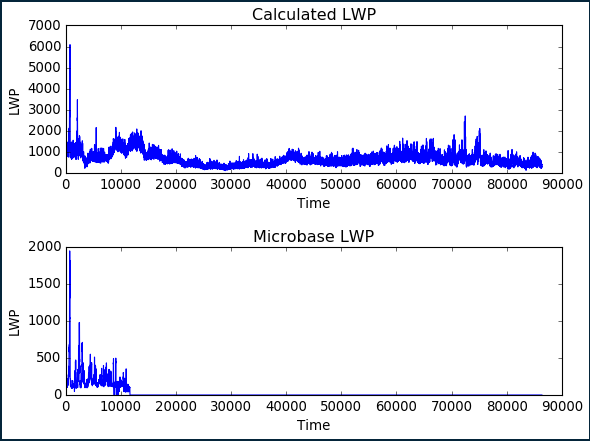

In [21]:
for d in days:
    l1,l2=lwp_val(d)